<a href="https://colab.research.google.com/github/abdullahArshadCheema/Artifical_Neural_Network_Model/blob/main/Image-Caption-Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Embedding, add


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extracting the file


In [ ]:
import zipfile

zip_ref =  zipfile.ZipFile('/content/drive/MyDrive/ANN_Datasets/Flickr_8k/archive.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/ANN_Datasets/Flickr_8k/unzipped')
zip_ref.close()

In [ ]:
BASE_DIR = '/content/drive/MyDrive/ANN_Datasets/Flickr_8k/unzipped'
WORKING_DIR = '/content/drive/MyDrive/Image Caption Generator' 

## Extracting the Image Features

In [ ]:
# load the model
model = VGG16()

# Restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Summarize
print(model.summary())

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    
    # load the image from the path
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    
    # covert image pixels to numpy array
    image = img_to_array(image)
    
    # reshape the image
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # preprocess the image data for VGG16
    image = preprocess_input(image)
    
    # extract features
    feature = model.predict(image, verbose=0)
    
    # get image id
    image_id = img_name.split('.')[0]
    
    # store the features
    features[image_id] = feature
    

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the captions data

In [ ]:
## read from captions.txt
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    caption_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# Iterate line by line
for line in tqdm(caption_doc.split('\n')):
    # split line by comma ','
    token = line.split(',')
    if len(line)<2:
        continue
    
    image_id, caption_list = token[0], token[1:]
    
    # remove extension from image_id '.jpg'
    image_id = image_id.split('.')[0]
    
    # convert caption list to string
    caption = " ".join(caption_list)
    
    # create list if needed
    if not image_id in mapping:
        mapping[image_id]= []
    
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

## Preprocessing the Captions Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            
            # take one caption at a time
            caption = captions[i]
            
            # Preprocessing Steps
            # 1. convert to lower case
            caption = caption.lower()
            
            # 2. delete digits, special chars etc.,
            caption = caption.replace('[^A-Za-z]','')
            
            # 3. remove extra spaces
            caption = caption.replace('\s+', ' ')
            
            # add start and end tags, also remove single char word
            caption = 'startseq '+ " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            
            # restore the processed caption
            captions[i] = caption
            

In [ ]:
clean(mapping)

In [ ]:
# storing all captions in a list
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
# tokenize the text
tokenizer =  Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)

## Train | Test Split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batches (to avoid session crash)
def generateData(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over image
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key in data_keys:
            n += 1
            # process each caption
            captions = mapping[key]
            for caption in captions:
                
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    
                    # split into input and output sequences
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
                if n == batch_size:
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                    yield [X1, X2], y
                    X1, X2, y = list(), list(), list()
                    n=0

## Model Creation

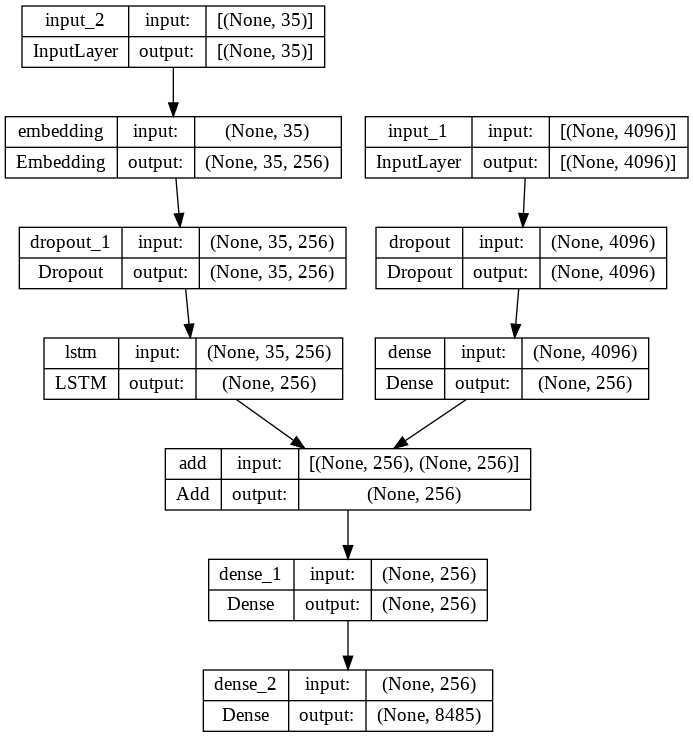

In [ ]:
# encoder model
# image feature layers
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
input2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

## Training the Model

In [ ]:
# train the model
epochs = 30
batch_size=64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = generateData(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  4/113 [>.............................] - ETA: 19:05 - loss: 8.0616

KeyboardInterrupt: ignored

In [ ]:
# save the model
model.save(WORKING_DIR, 'best_model.h5')


## Generate Caption for Image

In [ ]:
# Index to word conversion
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None    

In [ ]:
# generate caption for image
def predict_caption(image, model, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    
    # iterate over the max_length of sequence
    for i in range(max_length):
        
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        
        # predict new word
        yhat = model.predict([image, sequence], verbose=0)
        
        # get index with highest probability
        yhat = np.argmax(yhat)
        
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        
        # stop when work not found
        if word is None:
            break
        
        # append the word as input for generating next word
        in_text += ' ' + word
        
        # reach to end further word generation
        if word == 'endseq':
            break
    
    return in_text

## BLEU Score Computation

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    
    # predict the caption for image
    y_pred = predict_caption(features[key], model, tokenzier, max_length)
    
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    # append to the lists
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calculate BLEU score
print('BLEU-1: %f '% corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f '% corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

## Visualize the Results

In [ ]:
from PIL import Image
import mathplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    img_path = os.path.join(BASE_DIR, 'Images', image_name)
    image = Image(img_path)
    
    # retrieve actual captions
    image_id = image_name.split('.')[0]
    captions = mapping[image_id]
    
    # predict caption from the image
    y_predict = predict_caption(features[image_id], model, tokenizer, max_length)
    
    # display image with actual and predicted captions
    print('--------------------- Actual ----------------------')
    for caption in captions:
        print(caption)
    print('--------------------- Predicted -------------------')
    print(y_predict)
    
    plt.imshow(image)
